## Stable Diffusion fine tune with DreamBooth on SageMaker g4dn notebook
* Example for character/person training with captions
* Tested with ml.g4dn.xlarge SageMaker notebook, which has a NVIDIA T4 GPU with 16 GiB GPU memory.
* Content included training part and inference part.
* Major training codes were borrowed from [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth) and most of inference codes were borrowed from [Philschmid's blog](https://www.philschmid.de/sagemaker-stable-diffusion).

## SageMaker training

### Install dependencies

In [ ]:
%%writefile requirements.txt
accelerate
transformers>=4.25.1
ftfy
tensorboard
modelcards
natsort
safetensors

In [ ]:
!pip install -U pip
!pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install git+https://github.com/ShivamShrirao/diffusers.git
!pip install -U -r requirements.txt

### Install GPU memory optimization libraries

In [ ]:
!pip install bitsandbytes==0.35.4 # newly updated version of bitsandbytes made images into garbage, so freeze the version for now
!pip install -U triton
# !pip install xformers
!pip install xformers==0.0.18  # Changed to new version 0.0.18 in order to be suitable for notebook instance in g5 type

### Initialize an Accelerate environment 

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

### Get training scripts from ShivamShrirao's repo

In [5]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py

### Train a modle for generating a person in cyberpunk style  
* "Character/Person" training with captions example, you can also train without caoptions
* More information you can refer to [ShivamShrirao's repo](https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth)
* Training parameters are also optimized according to [this thread](https://github.com/d8ahazard/sd_dreambooth_extension/discussions/547)

In [6]:
MODEL_NAME = "runwayml/stable-diffusion-v1-5" 
OUTPUT_DIR = "stable_diffusion_weights/dreambooth_fine_tune"
INSTANCE_DATA_DIR = "images/sample"
IMAGES_OUTPTS = "images/outputs"
!mkdir -p $OUTPUT_DIR $INSTANCE_DATA_DIR $IMAGES_OUTPTS

In [ ]:
!git clone https://github.com/terrificdm/dreambooth-stablediffusion-sagemaker-notebook
!cp -r dreambooth-stablediffusion-sagemaker-notebook/images/Wikipe-tan/* $INSTANCE_DATA_DIR
!rm -rf dreambooth-stablediffusion-sagemaker-notebook

In [8]:
import os

file_list = [f for f in os.listdir(INSTANCE_DATA_DIR) if f.endswith('.txt')]
for file_name in file_list:
    new_file_name = file_name.replace('.txt', '.png.txt')
    os.rename(INSTANCE_DATA_DIR+'/'+file_name, INSTANCE_DATA_DIR+'/'+new_file_name)

In [9]:
# Due to SageMaker upgrade notebook kernel recently, you might encounter error like "ImportError: /lib64/libstdc++.so.6: version `GLIBCXX_3.4.26' not found", use below scripts to avoid
!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

In [10]:
!rm -rf /home/ec2-user/SageMaker/images/sample/.ipynb_checkpoints

In [ ]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --read_prompts_from_txts \
  --resolution=512 \
  --train_batch_size=2 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=8e-7 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=848 \
  # --save_interval=500 \

### Mode inference testing

In [ ]:
from natsort import natsorted
from glob import glob
import os
WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")    

You have disabled the safety checker for <class 'diffusers_modules.git.lpw_stable_diffusion.StableDiffusionLongPromptWeightingPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

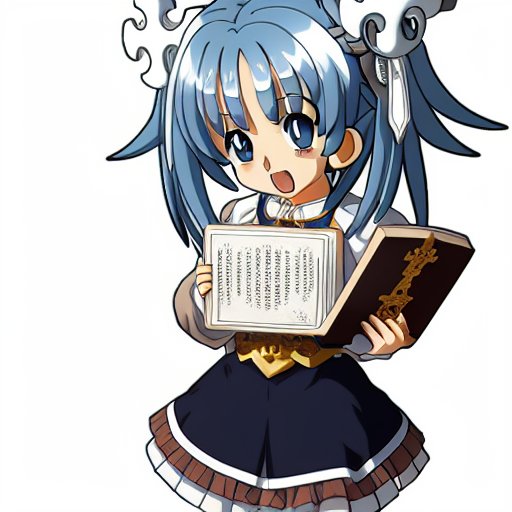

images/outputs/7561811740870856_2023-04-23 11:19:58.png



  0%|          | 0/20 [00:00<?, ?it/s]

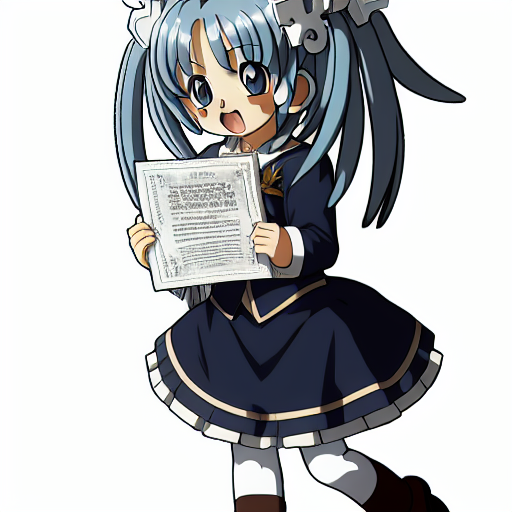

images/outputs/991047592730699_2023-04-23 11:20:01.png


Seeds for generating images: [7561811740870856, 991047592730699]



In [22]:
import torch
import datetime

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler
model_dir = WEIGHTS_DIR

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = StableDiffusionPipeline.from_pretrained(model_dir, custom_pipeline="lpw_stable_diffusion", scheduler=scheduler, torch_dtype=torch.float16) # Add custom pipeline to support long prompt
pipe = pipe.to("cuda")
prompt = "1girl, looking_at_viewer, blue_hair, short_twintails, hair_ornament, blue_eyes, blush, smile, open_mouth, shirt, skirt, kneehighs, brown_footwear, standing, solo, white background, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark"

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=512,
        width=512,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7.5,
        generator = generator
    ).images[0]
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    
# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")

  0%|          | 0/20 [00:00<?, ?it/s]

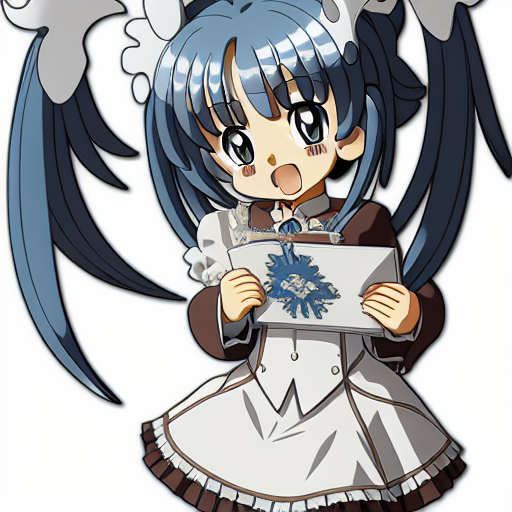

In [21]:
# Comment below codes, if you don't want to produce the same images again
seed = seeds[0] # use the first seed
generator.manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=512,
    width=512,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7.5,
    generator = generator
).images[0]
display(image)

### Use scripts to convert weights to ckpt to use in web UIs like AUTOMATIC1111
* For how to use "Stable Diffusion web UI" of AUTOMATIC1111, please refer to this [repo](https://github.com/AUTOMATIC1111/stable-diffusion-webui)
* DreamBooth plugin can also be implemented for "Stable Diffusion web UI" to fine tune the model
* You can also use other methods provided by webUI to fine tune the model.

In [15]:
# uncomment below codes if you want to generate ckpt file for web UI

# !wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
# ckpt_path = WEIGHTS_DIR + "/model.ckpt"
# half_arg = ""
# #@markdown  Whether to convert to fp16, takes half the space (2GB).
# fp16 = False #@param {type: "boolean"}
# if fp16:
#     half_arg = "--half"
# !python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
# print(f"[*] Converted ckpt saved at {ckpt_path}")